# code for making low-dimensional plots

In [1]:
import os
# os.environ['XLA_PYTHON_CLIENT_ALLOCATOR']='platform'

os.environ['CUDA_VISIBLE_DEVICES']='0' # can be 0-6 - check it's free

import jax
# jax.config.update('jax_platform_name', 'cpu')

import jax.numpy as jnp
import numpy as np

import matplotlib.pyplot as plt

from src.diffusion import VE_diffuser, log_hat_pt, empirical_eps_fn, sample_rev
from src.smoothing import get_smoothed_fn

# plot formatting
import seaborn as sns
from matplotlib.lines import Line2D
sns.set_theme()  # sets a nicer global style for plots
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'font.family': 'serif'})

## Figure 1

In [2]:
def sample_curve(J, curve_fn, sampling_mode="equally_spaced", return_thetas=False, rng=None, endpoint=False):
    # samples J points from a curve defined by curve_fn
    if sampling_mode == "equally_spaced":
        ts = jnp.linspace(0, 2 * jnp.pi, 1000)
        points = jax.vmap(curve_fn)(ts)
        segment_lengths = jnp.sqrt(jnp.sum(jnp.diff(points, axis=0)**2, axis=1))
        arc_lengths = jnp.concatenate([jnp.array([0]), jnp.cumsum(segment_lengths)])
        normalized_arc_lengths = arc_lengths / arc_lengths[-1]
        target_arc_lengths = jnp.linspace(0, 1, J, endpoint=endpoint)
        thetas = jnp.interp(target_arc_lengths, normalized_arc_lengths, ts)

    elif sampling_mode == "uniform_theta":
        thetas = jnp.linspace(0, 2 * jnp.pi, J, endpoint=endpoint) 

    elif sampling_mode == "uniform_random":
        N = 5000
        ts = jnp.linspace(0, 2 * jnp.pi, N)
        points = jax.vmap(curve_fn)(ts)
        segment_lengths = jnp.sqrt(jnp.sum(jnp.diff(points, axis=0)**2, axis=1))
        arc_lengths = jnp.concatenate([jnp.array([0]), jnp.cumsum(segment_lengths)])
        normalized_arc_lengths = arc_lengths / arc_lengths[-1]
        target_arc_lengths = jnp.linspace(0, 1, N, endpoint=endpoint)
        uniform_spaces_thetas = jnp.interp(target_arc_lengths, normalized_arc_lengths, ts)
        thetas = jax.random.choice(rng, uniform_spaces_thetas, shape=(J,), replace=False)
    
    points = jax.vmap(curve_fn)(thetas)

    if return_thetas:
        return points, thetas
    else:
        return points
    
def get_lima_bean_curve_fn(a, b, scale, rot = jnp.pi / 4, centre_theta = jnp.pi, scale_theta = 0.5):
    # parameterises the lima bean shape
    def lima_bean_curve_fn(theta):
        theta = scale_theta * (theta - jnp.pi) + centre_theta
        r = jnp.sin(theta)**a + jnp.cos(theta)**b
        x = scale * r * jnp.cos(theta)
        y = scale * r * jnp.sin(theta)
        R = jnp.array([[jnp.cos(rot), -jnp.sin(rot)],[jnp.sin(rot), jnp.cos(rot)]])
        return R @ jnp.array([x, y])
    return lima_bean_curve_fn

In [3]:
# get datapoints
rng = jax.random.PRNGKey(1)
DATA_SIZE = 30
DIM = 2
shape = (2,)
a = 3
b = 3
scale = 1
curve_fn = get_lima_bean_curve_fn(a, b, scale, rot=jnp.pi/2)

rng = jax.random.PRNGKey(1)
rng, rng_ = jax.random.split(rng)
Data = sample_curve(DATA_SIZE, curve_fn, sampling_mode="uniform_random", rng=rng_) # data for empirical measure

Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/home/howard/python_envs/jax/lib/python3.10/site-packages/jax/_src/xla_bridge.py", line 442, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/home/howard/python_envs/jax/lib/python3.10/site-packages/jax_plugins/xla_cuda12/__init__.py", line 78, in initialize
    options = xla_client.generate_pjrt_gpu_plugin_options()
AttributeError: module 'jaxlib.xla_client' has no attribute 'generate_pjrt_gpu_plugin_options'


2026-01-04 15:07:50.033300: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.52). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


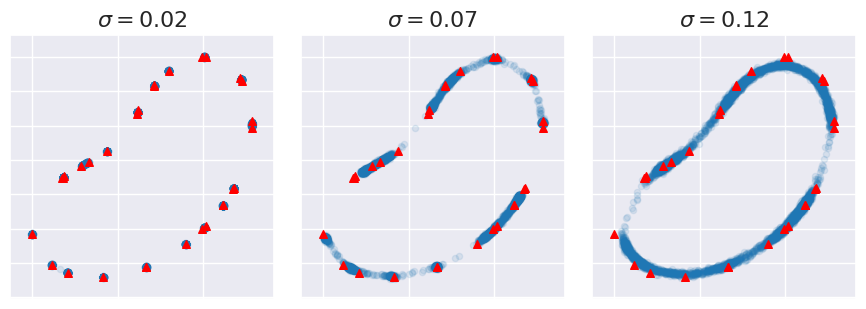

In [4]:
# define the VE diffusion object
ve = VE_diffuser(sigma_min=0.001, sigma_max=2.0)

# plot samples from smoothed empirical score functions with different smoothing parameters
smoothing_params = [0.02, 0.07, 0.12]
data_empirical_eps_fn = lambda x, t, key: empirical_eps_fn(x, Data, t) # empirical score function
num_samples = 5000

num = len(smoothing_params)
fig, axs = plt.subplots(1, num, figsize=(3 * num, 4), sharex=True, sharey=True)

rng, sample_rng = jax.random.split(rng) # Using same keys for all smoothing parameters
for i in range(num):
    smoothing_param = smoothing_params[i]
    smoothed_emp_eps_fn = get_smoothed_fn(data_empirical_eps_fn, smoothing_param, n=200) # smoothed score function

    smoothed_samples, traj = sample_rev(ve, sample_rng, smoothed_emp_eps_fn, num_samples, image_shape=shape, num_steps=100) # sample with smoothed score function

    # add to plot
    axs[i].scatter(smoothed_samples[:, 0], smoothed_samples[:, 1], alpha=0.1, c='tab:blue', s=20)
    axs[i].scatter(Data[:, 0], Data[:, 1], alpha=1, c='red', s=30, marker="^")
    axs[i].set_title(f"$\sigma = {smoothing_param}$", fontsize=16)
    axs[i].set_aspect('equal', 'box')
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])

    x_min, x_max = Data[:, 0].min(), Data[:, 0].max()
    y_min, y_max = Data[:, 1].min(), Data[:, 1].max()
    x_padding = (x_max - x_min) * 0.1  # 20% padding
    y_padding = (y_max - y_min) * 0.1  # 20% padding

    axs[i].set_xlim(x_min - x_padding, x_max + x_padding)
    axs[i].set_ylim(y_min - y_padding, y_max + y_padding)

plt.tight_layout()

## Figure 2

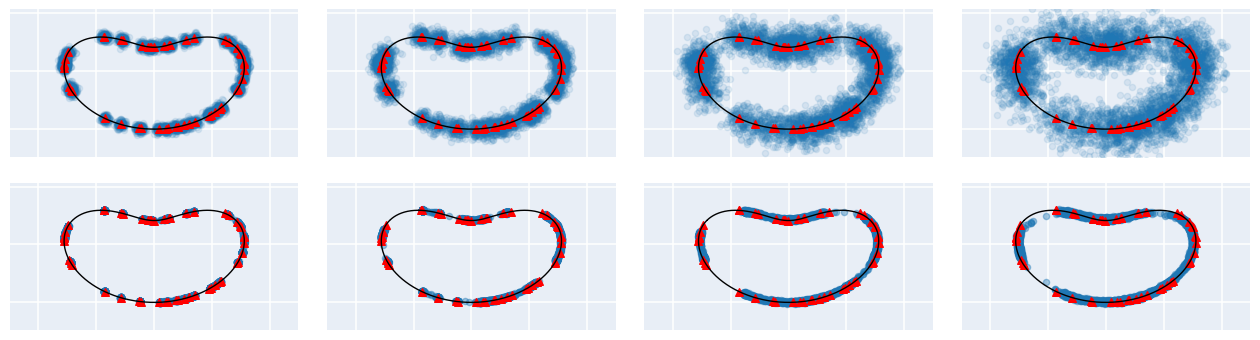

In [5]:
rng = jax.random.key(42)
DIM = 2
n_data = 50
n_samples = 5000

# Curve
curve_fn = get_lima_bean_curve_fn(a=3, b=3, scale=1.0, rot=jnp.pi/4)
Curve = sample_curve(1000, curve_fn, sampling_mode="uniform_theta")
rng, rng_data = jax.random.split(rng)
Data = sample_curve(n_data, curve_fn, sampling_mode="uniform_random", rng=rng_data) # data for empirical measure

# define the VE diffusion object
ve = VE_diffuser(sigma_min=0.001, sigma_max=2.0)

# plot samples from smoothed empirical score functions with different smoothing parameters
smoothing_params = [0.02, 0.04, 0.07, 0.1]
data_empirical_eps_fn = lambda x, t, key: empirical_eps_fn(x, Data, t) # empirical score function
num_samples = 5000

# Make grid of plots
fig, axs = plt.subplots(2, len(smoothing_params), figsize=(4*len(smoothing_params), 4.5), sharex=True, sharey=True)

rng, sample_rng = jax.random.split(rng) # Using same keys for all smoothing parameters
for i, smoothing_param in enumerate(smoothing_params):

    # --- Top row: KDE
    from sklearn.neighbors import KernelDensity
    kde = KernelDensity(kernel="gaussian", bandwidth=smoothing_param)
    kde.fit(np.array(Data))
    rng_kde = np.random.RandomState(0)
    samples_kde = kde.sample(n_samples, random_state=rng_kde)

    axs[0, i].scatter(samples_kde[:,0], samples_kde[:,1], alpha=0.1, c="tab:blue", s=20)
    axs[0, i].scatter(np.array(Data)[:,0], np.array(Data)[:,1], c="red", s=30, marker="^", alpha=1)
    axs[0, i].plot(np.array(Curve)[:,0], np.array(Curve)[:,1], c="black", linewidth=1)

    # --- Bottom row: score smoothing
    smoothed_emp_eps_fn = get_smoothed_fn(data_empirical_eps_fn, smoothing_param, n=200) # smoothed score function

    smoothed_samples, traj = sample_rev(ve, sample_rng, smoothed_emp_eps_fn, num_samples, image_shape=shape, num_steps=100) # sample with smoothed score function

    axs[1, i].scatter(smoothed_samples[:, 0], smoothed_samples[:, 1], alpha=0.4, c='tab:blue', s=20)
    axs[1, i].scatter(Data[:, 0], Data[:, 1], alpha=1, c='red', s=30, marker="^")
    axs[1, i].plot(np.array(Curve)[:,0], np.array(Curve)[:,1], c="black", linewidth=1)

# plot formatting
ts = jnp.linspace(0, 2*jnp.pi, 2000)
curve_points = jax.vmap(curve_fn)(ts)
xmin, ymin = curve_points.min(0)
xmax, ymax = curve_points.max(0)

# Add ~10% padding so lima bean doesn’t touch subplot borders
padding_x = 0.3 * (xmax - xmin)
padding_y = 0.3 * (ymax - ymin)

xlim = (float(xmin - padding_x), float(xmax + padding_x))
ylim = (float(ymin - padding_y), float(ymax + padding_y))

for ax in axs.flat:
    ax.set_facecolor("#E8EEF6")
    ax.grid(True, color="white", linewidth=1.1)
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    # make the bean fill the rectangle
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_aspect('equal', 'box')
    ax.margins(x=0, y=0)      # no extra matplotlib auto-margin
    ax.autoscale(False)       # keep our limits fixed

plt.subplots_adjust(wspace=0.1, hspace=0.0)
plt.show()

## Figure 5

In [6]:
def get_sin_circle_curve_fn(freq=5, amp=0.2, scale=1):
    # parameterises a wavy circle
    def sin_circle_curve_fn(theta):
        x = jnp.cos(theta) * (1 + amp * jnp.sin(freq * theta))
        y = jnp.sin(theta) * (1 + amp * jnp.sin(freq * theta))
        point = jnp.array([x, y])
        return scale * point
    return sin_circle_curve_fn

DATA_SIZE = 30
FREQ = 8    
AMP = 0.13
SCALE = 1
curve_fn = get_sin_circle_curve_fn(FREQ, AMP, SCALE)
Data = sample_curve(DATA_SIZE, curve_fn, sampling_mode="equally_spaced")

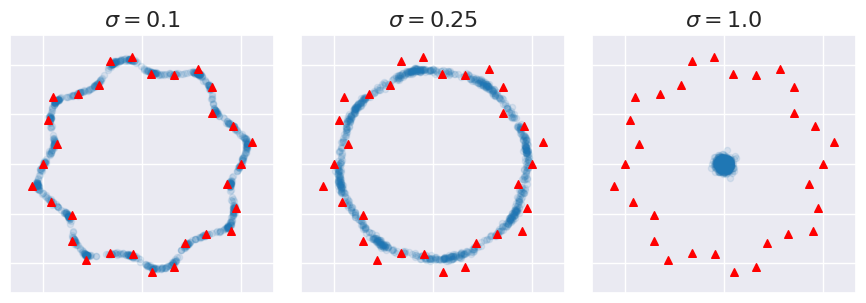

In [7]:
# plot samples from smoothed empirical score functions with different smoothing parameters
smoothing_params = [0.1, 0.25, 1.0]
data_empirical_eps_fn = lambda x, t, key: empirical_eps_fn(x, Data, t)
num_samples = 1000

num = len(smoothing_params)
fig, axs = plt.subplots(1, num, figsize=(3 * num, 4), sharex=True, sharey=True)

rng, sample_rng = jax.random.split(rng) # Using same keys for all smoothing parameters
for i in range(num):
    smoothing_param = smoothing_params[i]
    smoothed_emp_eps_fn = get_smoothed_fn(data_empirical_eps_fn, smoothing_param, n=200)

    smoothed_samples, traj = sample_rev(ve, sample_rng, smoothed_emp_eps_fn, num_samples, image_shape=shape, num_steps=100) # sample with smoothed score function

    axs[i].scatter(smoothed_samples[:, 0], smoothed_samples[:, 1], alpha=0.1, c='tab:blue', s=20)
    axs[i].scatter(Data[:, 0], Data[:, 1], alpha=1, c='red', s=30, marker="^")
    axs[i].set_title(f"$\sigma = {smoothing_param}$", fontsize=16)
    axs[i].set_aspect('equal', 'box')
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])

    x_min, x_max = Data[:, 0].min(), Data[:, 0].max()
    y_min, y_max = Data[:, 1].min(), Data[:, 1].max()
    x_padding = (x_max - x_min) * 0.1  # 20% padding
    y_padding = (y_max - y_min) * 0.1  # 20% padding

    axs[i].set_xlim(x_min - x_padding, x_max + x_padding)
    axs[i].set_ylim(y_min - y_padding, y_max + y_padding)

plt.tight_layout()